# Extrapolate Wakefield results

In [1]:
import sys
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.constants import c 

sys.path.append('../wakis/')
import wakis

sys.path.append('../IDDEFIX/')
import iddefix

Let's load the simulation results computed in the notebook `002`

In [2]:
wake30 = wakis.WakeSolver()
wake30.load_results('results_wl30/')
wake_length = 30

Text(0.5, 0, 's [m]')

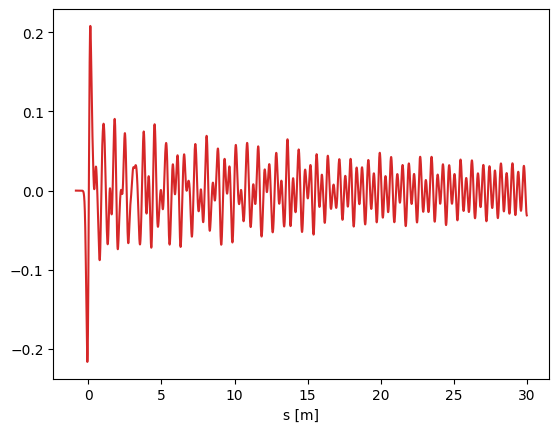

In [3]:
fig, ax = plt.subplots()
ax.plot(wake30.s, wake30.WP, c='tab:red', label='Wakelength = 10 m')
ax.set_xlabel('s [m]')

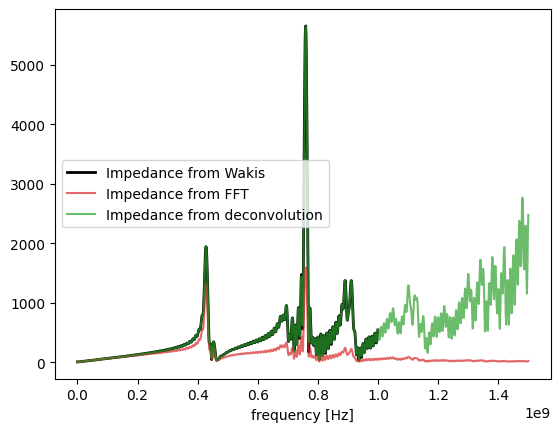

In [4]:
fig, ax = plt.subplots()
ax.plot(wake30.f, np.abs(wake30.Z), c='k', lw=2, label='Impedance from Wakis')
f, WP_fft = iddefix.compute_fft(wake30.s/c, wake30.WP*1e12/c, fmax=1.5e9)
ax.plot(f, np.abs(WP_fft), c='tab:red', alpha=0.7, label='Impedance from FFT')
f, Z = iddefix.compute_deconvolution(wake30.s/c, wake30.WP*1e12/c, fmax=1.5e9, sigma=10e-2/c)
ax.plot(f, np.abs(Z), c='tab:green', alpha=0.7, label='Impedance from deconvolution')
ax.set_xlabel('frequency [Hz]')
ax.legend()

Now we get the number of resonators and parameters for the Differential Evolution model `DE_model`

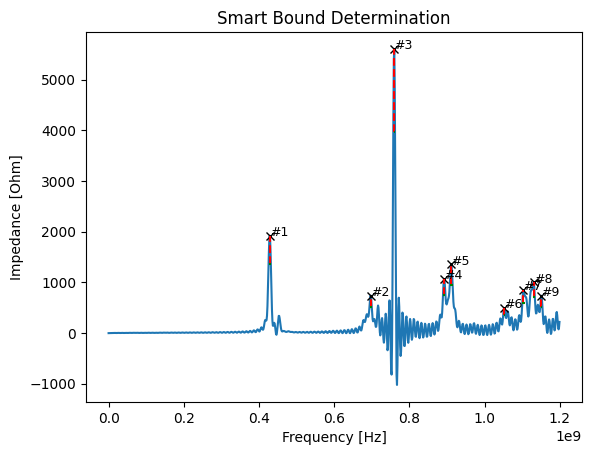

In [5]:
f,Z = iddefix.compute_deconvolution(wake30.s/c, wake30.WP*1e12/c, samples=1000, fmax=1.2e9, sigma=10e-2/c)
Z *= -1.0 # longitudinal impedance normalization

# Interpolate data
#f = np.linspace(ff[0],ff[-1],100)
#Z = np.interp(f, ff, Z)

heights = np.zeros_like(Z)
heights[:] = 450
heights[np.logical_and(f>0.70e9,f<0.8e9)] = 3000

bounds = iddefix.SmartBoundDetermination(f, np.real(Z), minimum_peak_height=500)
bounds.find(minimum_peak_height=heights, distance=10 )
bounds.inspect()

In [6]:
bounds.to_table()


--------------------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |        fres [Hz]        
--------------------------------------------------------------------------------
    1     |  1535.31 to 19191.42   | 44.63 to 446.25  |  4.19e+08 to 4.39e+08   
    2     |   589.07 to 7363.39    | 72.63 to 726.25  |  6.87e+08 to 7.07e+08   
    3     |  4486.91 to 56086.43   |158.25 to 1582.50 |  7.50e+08 to 7.70e+08   
    4     |   848.38 to 10604.70   | 61.92 to 619.17  |  8.82e+08 to 9.02e+08   
    5     |  1081.48 to 13518.54   | 63.25 to 632.50  |  9.01e+08 to 9.21e+08   
    6     |   391.38 to 4892.27    |109.63 to 1096.25 |  1.04e+09 to 1.06e+09   
    7     |   674.27 to 8428.33    | 76.58 to 765.83  |  1.09e+09 to 1.11e+09   
    8     |   799.80 to 9997.45    |117.75 to 1177.50 |  1.12e+09 to 1.14e+09   
    9     |   588.25 to 7353.17    |119.88 to 1198.75 |  1.14e+09 to 1.16e+09   
---------------------------

## Option A: Use the wake data for the fitting

In [ ]:
# Decimate data to improve speed
s = np.linspace(wake30.s[1000],wake30.s[-1],1000)
WP = np.interp(s, wake30.s, wake30.WP)

fig, ax = plt.subplots()
ax.plot(wake30.s, wake30.WP)
ax.plot(s, WP)

In [ ]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(s/c, 
                                         WP*1e12/c, 
                                         N_resonators=bounds.N_resonators, 
                                         parameterBounds=bounds.parameterBounds,
                                         sigma=10e-2/c,
                                         plane='longitudinal',
                                         fitFunction='wake potential', 
                                         objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal
                                         ) 

# Run the differential evolution
DE_model.run_differential_evolution(maxiter=3000,
                                    popsize=100,
                                    tol=0.001,
                                    mutation=(0.5, 0.8),
                                    crossover_rate=0.8)
print(DE_model.warning)

## Option B: use the impedance data for fitting

In [7]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(f, 
                                         Z.real, 
                                         N_resonators=bounds.N_resonators, 
                                         parameterBounds=bounds.parameterBounds,
                                         plane='longitudinal',
                                         fitFunction='impedance', 
                                         wake_length=wake_length, # in [m]
                                         objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal
                                         ) 

# Run the differential evolution
DE_model.run_differential_evolution(maxiter=30000,
                                    popsize=150,
                                    tol=0.001,
                                    mutation=(0.3, 0.8),
                                    crossover_rate=0.5)
print(DE_model.warning)

[!] Using the partially decayed resonator formalism for impedance


Optimization Progress %: 100.57220185791246it [09:45,  5.83s/it]                              



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.17e+03        |      63.22       |    4.285e+08     
    2     |        8.09e+02        |      72.73       |    6.965e+08     
    3     |        2.43e+04        |      899.59      |    7.595e+08     
    4     |        8.71e+02        |      84.45       |    8.923e+08     
    5     |        1.21e+03        |      68.35       |    9.113e+08     
    6     |        5.68e+02        |      109.87      |    1.055e+09     
    7     |        8.26e+02        |      76.62       |    1.106e+09     
    8     |        1.06e+03        |      117.80      |    1.128e+09     
    9     |        6.83e+02        |      119.96      |    1.150e+09     
----------------------------------------------------------------------
callback function requested stop early
CPU ti

In [10]:
DE_model.run_minimization_algorithm(margin=[0.3, 0.2, 0.01])

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.23e+03        |      65.17       |    4.285e+08     
    2     |        7.70e+02        |      58.92       |    6.964e+08     
    3     |        2.80e+04        |     1058.72      |    7.595e+08     
    4     |        9.27e+02        |      93.07       |    8.924e+08     
    5     |        1.25e+03        |      71.49       |    9.112e+08     
    6     |        5.34e+02        |      89.27       |    1.055e+09     
    7     |        7.89e+02        |      74.83       |    1.105e+09     
    8     |        9.92e+02        |      97.96       |    1.128e+09     
    9     |        6.18e+02        |      99.67       |    1.150e+09     
----------------------------------------------------------------------


## Option C: Load previously computed parameters

In [15]:
DE_model = iddefix.EvolutionaryAlgorithm(f, 
                                         Z.real, 
                                         N_resonators=bounds.N_resonators, 
                                         parameterBounds=bounds.parameterBounds,
                                         plane='longitudinal',
                                         fitFunction='impedance', 
                                         wake_length=wake_length, # in [m]
                                         objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal
                                         ) 
from io import StringIO
data_str = StringIO('''
----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.17e+03        |      63.22       |    4.285e+08     
    2     |        8.09e+02        |      72.73       |    6.965e+08     
    3     |        2.43e+04        |      899.59      |    7.595e+08     
    4     |        8.71e+02        |      84.45       |    8.923e+08     
    5     |        1.21e+03        |      68.35       |    9.113e+08     
    6     |        5.68e+02        |      109.87      |    1.055e+09     
    7     |        8.26e+02        |      76.62       |    1.106e+09     
    8     |        1.06e+03        |      117.80      |    1.128e+09     
    9     |        6.83e+02        |      119.96      |    1.150e+09     
----------------------------------------------------------------------
''')

DE_model.evolutionParameters = np.loadtxt(data_str, 
                                            skiprows=4, max_rows=9, usecols=(1, 2, 3),
                                            delimiter='|', dtype=float,).flatten()

from io import StringIO
data_str = StringIO('''
----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.23e+03        |      65.17       |    4.285e+08     
    2     |        7.70e+02        |      58.92       |    6.964e+08     
    3     |        2.80e+04        |     1058.72      |    7.595e+08     
    4     |        9.27e+02        |      93.07       |    8.924e+08     
    5     |        1.25e+03        |      71.49       |    9.112e+08     
    6     |        5.34e+02        |      89.27       |    1.055e+09     
    7     |        7.89e+02        |      74.83       |    1.105e+09     
    8     |        9.92e+02        |      97.96       |    1.128e+09     
    9     |        6.18e+02        |      99.67       |    1.150e+09     
----------------------------------------------------------------------
''')

DE_model.minimizationParameters = np.loadtxt(data_str, 
                                            skiprows=4, max_rows=9, usecols=(1, 2, 3),
                                            delimiter='|', dtype=float,).flatten()

[!] Using the partially decayed resonator formalism for impedance


Show fully decayed wake function, wake potential and impedance

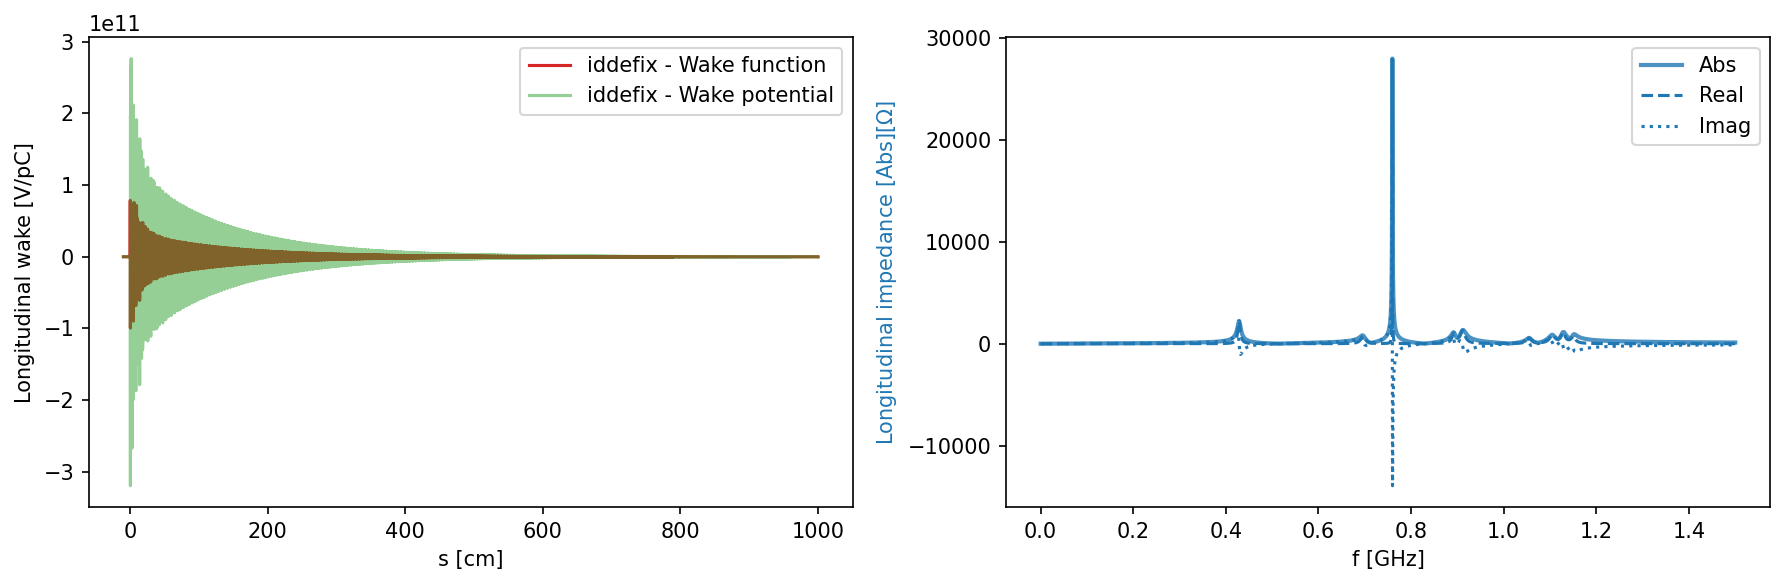

In [67]:
t_fd = np.linspace(-10/c, 1000/c, 10000)
WP_fd = DE_model.get_wake_potential(t_fd, sigma=10e-2/c)
W_fd = DE_model.get_wake(t_fd)

f_fd = np.linspace(0, 1.5e9, 10000)
Z_fd = DE_model.get_impedance(f_fd)

fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(t_fd*c, WP_fd, c='tab:red', lw=1.5, label='iddefix - Wake function')
ax[0].plot(t_fd*c, W_fd, c='tab:green', alpha=0.5, lw=1.5, label='iddefix - Wake potential')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake [V/pC]', color='k')
ax[0].legend()

ax[1].plot(f_fd*1e-9, np.abs(Z_fd), c='tab:blue', alpha=0.8, lw=2, label='Abs')
ax[1].plot(f_fd*1e-9, np.real(Z_fd), ls='--', c='tab:blue', lw=1.5, label='Real')
ax[1].plot(f_fd*1e-9, np.imag(Z_fd), ls=':', c='tab:blue', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()

Compare the fitting

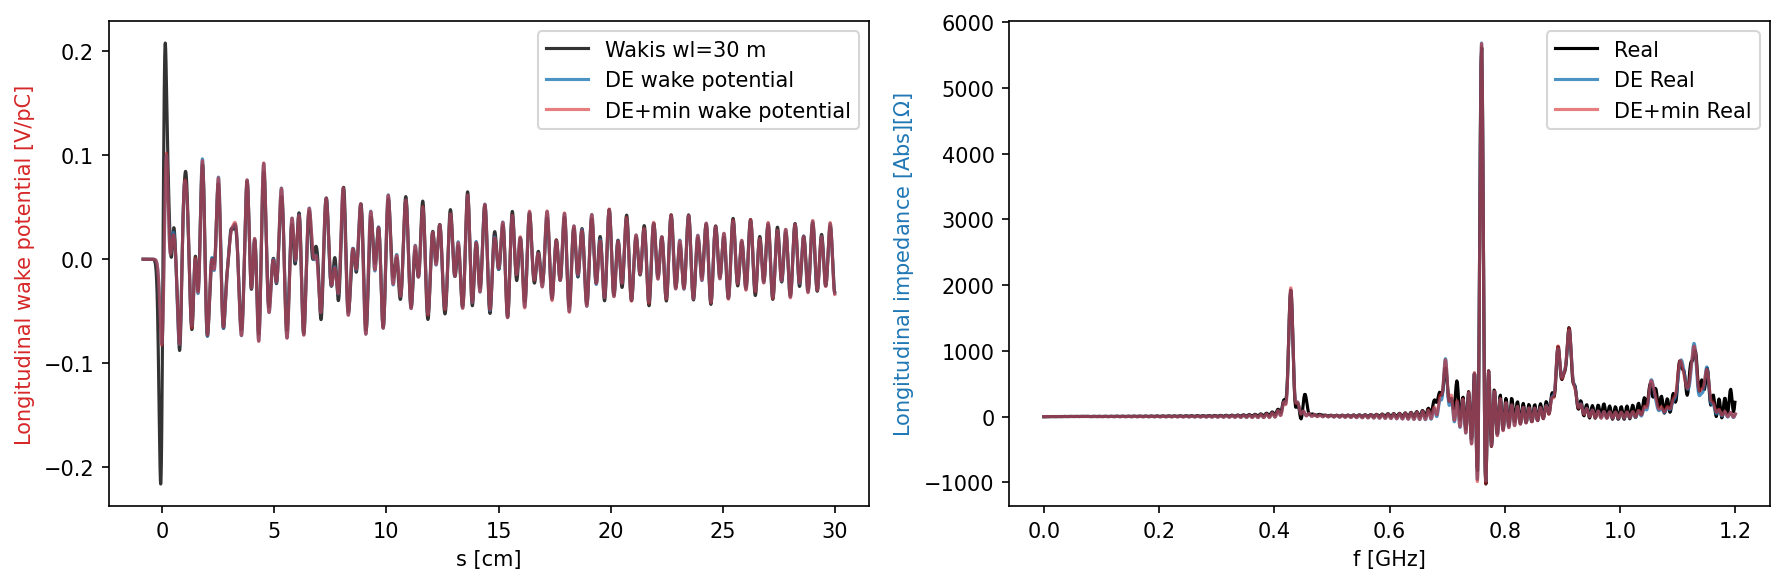

In [21]:
#%matplotlib ipympl

# Retrieve partially decayed wake potential
WP_pd = DE_model.get_wake_potential(wake30.s/c, sigma=10e-2/c, use_minimization=False)
WP_pd_min = DE_model.get_wake_potential(wake30.s/c, sigma=10e-2/c)

# Retrieve partially decayed impedance
f_pd = np.linspace(0, 1.2e9, 10000)
Z_pd = DE_model.get_impedance_from_fitFunction(f_pd, use_minimization=False)
Z_pd_min = DE_model.get_impedance_from_fitFunction(f_pd, use_minimization=True)

fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)

ax[0].plot(wake30.s, wake30.WP, c='k', alpha=0.8, label='Wakis wl=30 m')
ax[0].plot(wake30.s, -WP_pd*1e-12, c='tab:blue', alpha=0.8, lw=1.5, label='DE wake potential')
ax[0].plot(wake30.s, -WP_pd_min*1e-12, c='tab:red', alpha=0.6, lw=1.5, label='DE+min wake potential')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()

#ax[1].plot(wake30.f*1e-9, np.real(wake30.Z), c='k', label='Wakis wl=30 m')
#ax[1].plot(wake30.f*1e-9, np.real(wake30.Z), ls='-', c='k', lw=1.5, label='Real')
#ax[1].plot(wake30.f*1e-9, np.imag(wake30.Z), ls=':', c='k', lw=1.5, label='Imag')

ax[1].plot(f*1e-9, np.real(Z), ls='-', c='k', lw=1.5, label='Real')
#ax[1].plot(f*1e-9, np.imag(Z), ls=':', c='k', lw=1.5, label='Imag')
#ax[1].plot(f*1e-9, np.real(Z_pd), c='tab:blue', label='Abs')

ax[1].plot(f_pd*1e-9, np.real(Z_pd), ls='-', c='tab:blue', alpha=0.8, lw=1.5, label='DE Real')
#ax[1].plot(f_pd*1e-9, np.imag(Z_pd), ls=':', c='tab:blue', alpha=0.6, lw=1.5, label='DE Imag')

ax[1].plot(f_pd*1e-9, np.real(Z_pd_min), ls='-', c='tab:red', alpha=0.6, lw=1.5, label='DE+min Real')

ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()

### Compare to a longer Wakis simulation of 100 m

In [68]:
wake100 = wakis.WakeSolver()
wake100.load_results('results_wl100/')

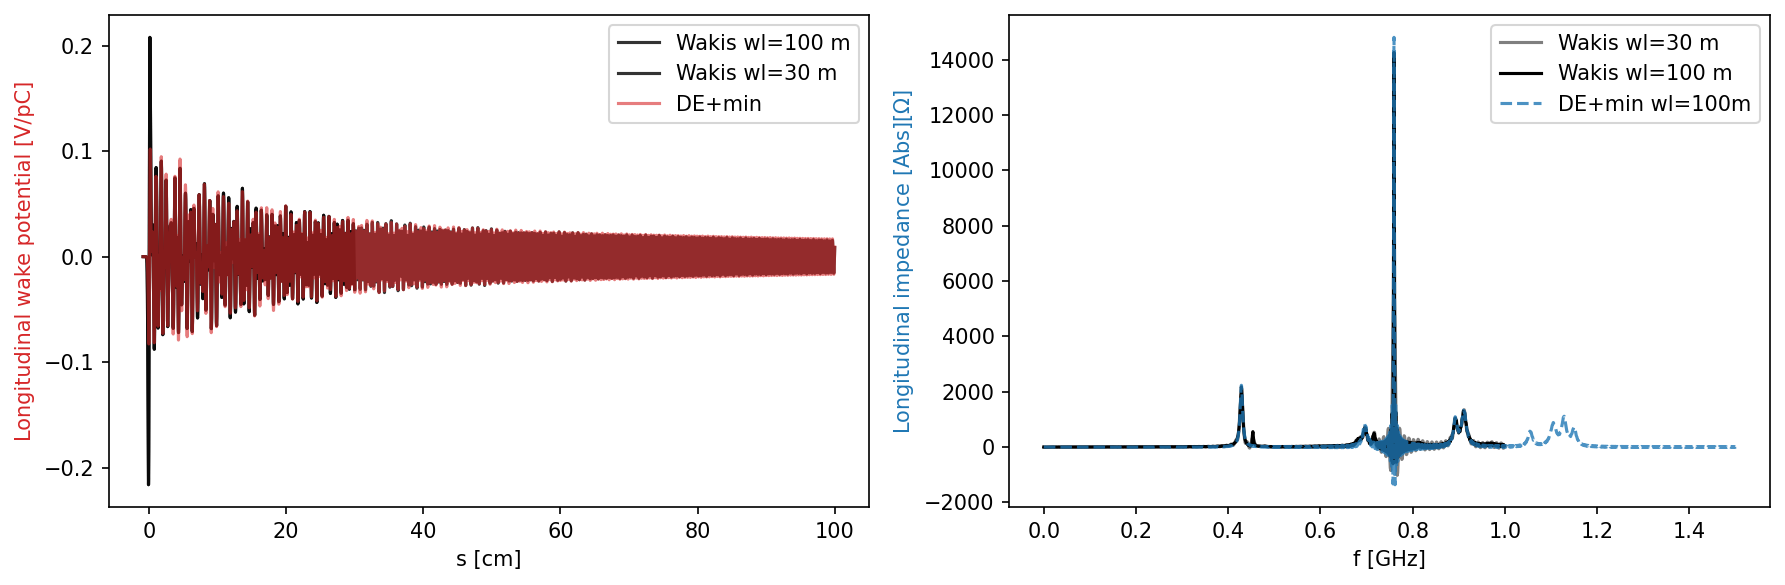

In [69]:
t_fd = np.linspace(wake100.s[0]/c, 100/c, 10000)
WP_fd = DE_model.get_wake_potential(t_fd, sigma=10e-2/c)

f_pd = np.linspace(0, 1.5e9, 10000)
Z_pd = DE_model.get_impedance(f_pd, wakelength=100)

#f_fd = np.linspace(0, 1.5e9, 10000)
#Z_fd = DE_model.get_impedance(f_fd)

fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(wake100.s, wake100.WP, c='k', alpha=0.8, label='Wakis wl=100 m')
ax[0].plot(wake30.s, wake30.WP, c='k', alpha=0.8, label='Wakis wl=30 m')
ax[0].plot(t_fd*c, -WP_fd*1e-12, c='tab:red', alpha=0.6, lw=1.5, label='DE+min')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()

ax[1].plot(wake30.f*1e-9, np.real(wake30.Z), c='k', alpha=0.5, label='Wakis wl=30 m')
ax[1].plot(wake100.f*1e-9, np.real(wake100.Z), c='k', label='Wakis wl=100 m')
ax[1].plot(f_pd*1e-9, np.real(Z_pd), ls='--', c='tab:blue', alpha=0.8, lw=1.5, label='DE+min wl=100m')
#ax[1].plot(f_fd*1e-9, np.real(Z_fd), ls='--', c='tab:red', alpha=0.8, lw=1.5, label='DE+min wl=inf')

ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()

### Extra: Compare the wake function analytical and the one computed by `neffint`

In [65]:
time, wake_function_100 = iddefix.compute_ineffint(wake100.f, wake100.Z, 
                                 times=np.linspace(1e-11, 30/c, 2000), #avoid starting at zero
                                 plane='longitudinal', #or longitudinal, changes normalization
                                 adaptative=False, # refines the sampling, but can be slow/unstable
                                 )

In [60]:
f_fd = np.linspace(0, 1.5e9, 1000)
Z_fd = DE_model.get_impedance(f_fd)
time_fd, wake_function_fd = iddefix.compute_ineffint(f_fd, Z_fd, 
                                 times=np.linspace(1e-11, 30/c, 2000), #avoid starting at zero
                                 plane='longitudinal', #or longitudinal, changes normalization
                                 adaptative=False, # refines the sampling, but can be slow/unstable
                                 )

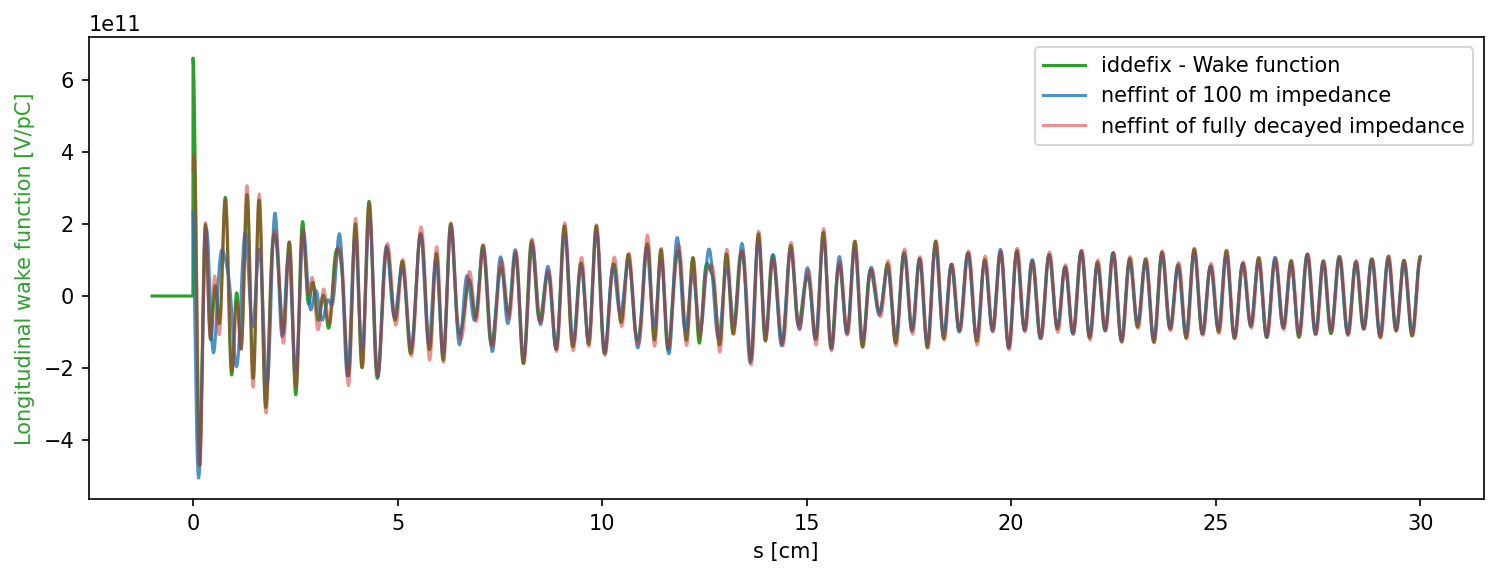

In [66]:
fig1, ax = plt.subplots(1,1,figsize=[12,4], dpi=150)

t = np.linspace(-1/c, 30/c, 10000)
W = DE_model.get_wake(t)

ax.plot(t*c, W, c='tab:green', lw=1.5, label='iddefix - Wake function')
ax.plot(time*c, wake_function_100, c='tab:blue', alpha=0.8, lw=1.5, label='neffint of 100 m impedance')
ax.plot(time_fd*c, wake_function_fd, c='tab:red', alpha=0.5, lw=1.5, label='neffint of fully decayed impedance')

#ax[0].plot(wake.s, wake.WP*np.pi, c='k', alpha=0.5, label='Wakis wl=30 m')
ax.set_xlabel('s [cm]')
ax.set_ylabel('Longitudinal wake function [V/pC]', color='tab:green')
ax.legend()